# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

09:23:36 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=764404;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=269279;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=7030;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=720532;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

09:24:27 INFO      Auto-determined polynomial order: 0                                ]8;id=932005;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=437602;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

09:24:44 INFO      None 0-order polynomial fit with the mle method                               ]8;id=146724;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=467714;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=204469;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=14325;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=470617;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=378054;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#525\525]8;;\

09:24:45 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=978244;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=187907;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#226\226]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=782365;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=591509;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#351\351]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=864760;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=390225;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=474768;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=700456;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=492656;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=589109;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=192752;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=776120;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

09:24:48 INFO      Now using 120 bins                                                          ]8;id=381812;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=932205;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

09:24:51 INFO      Auto-determined polynomial order: 1                                ]8;id=988311;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=474820;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

09:25:09 INFO      None 1-order polynomial fit with the mle method                               ]8;id=410125;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=90410;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=337717;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=897655;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=396229;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=468581;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#525\525]8;;\

09:25:10 INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=892231;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=712515;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#226\226]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=114695;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=861703;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#351\351]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=695699;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=115628;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=600059;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=136956;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=387094;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=146385;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=686258;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=267117;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=128613;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=840637;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

09:25:13 INFO      Auto-determined polynomial order: 1                                ]8;id=203788;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=308207;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

09:25:31 INFO      None 1-order polynomial fit with the mle method                               ]8;id=500034;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=702083;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=901166;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=8755;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=653311;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=682112;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#525\525]8;;\

09:25:32 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=550780;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=437057;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#226\226]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=116649;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=77952;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#351\351]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=719604;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=496162;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=542869;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=744760;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=208747;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=643532;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=431134;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=275872;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=597860;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=963184;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

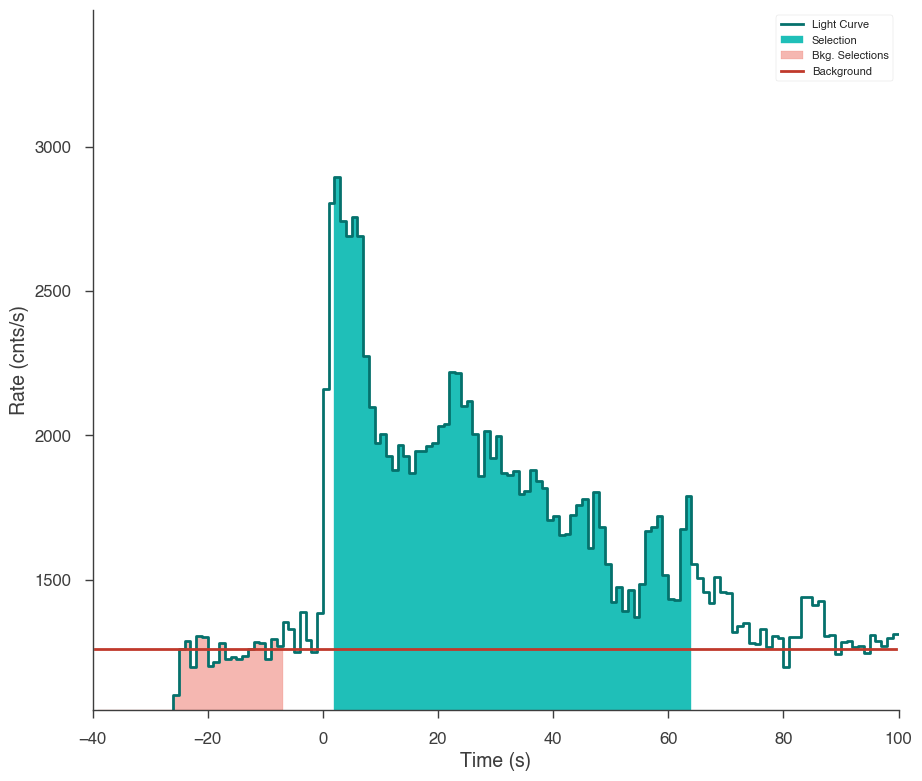

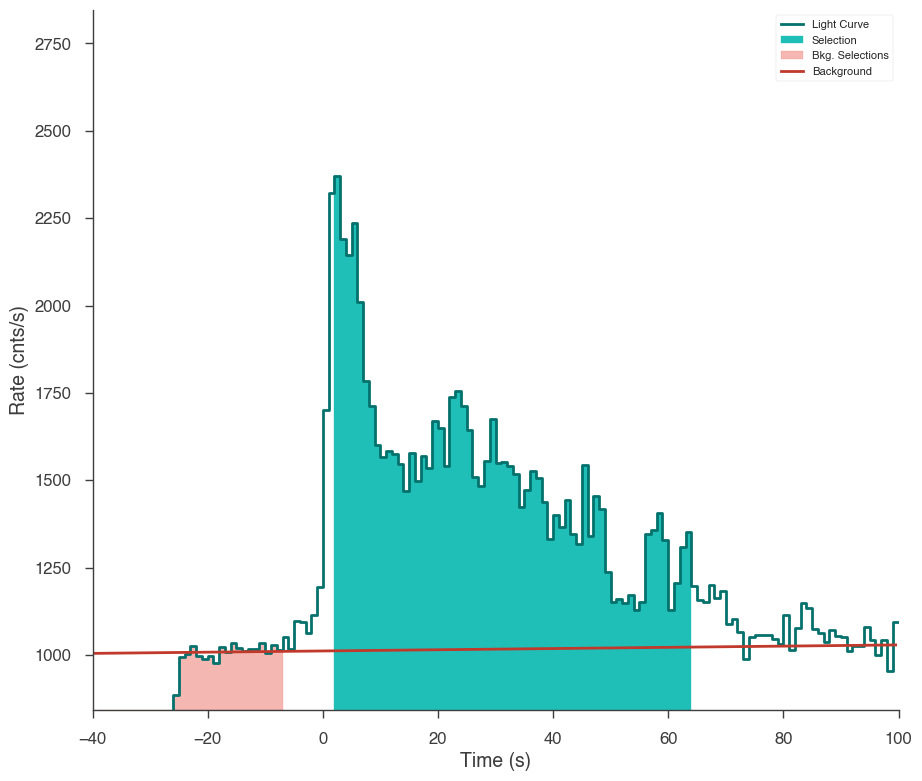

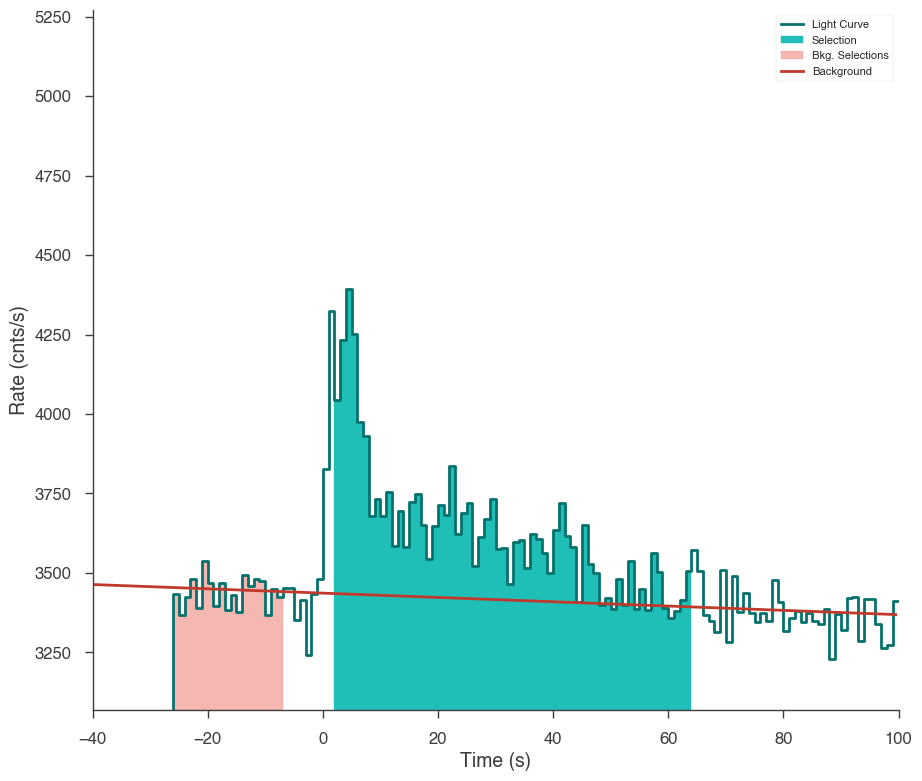

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

09:25:33 INFO      sampler set to multinest                                                ]8;id=858784;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=70692;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

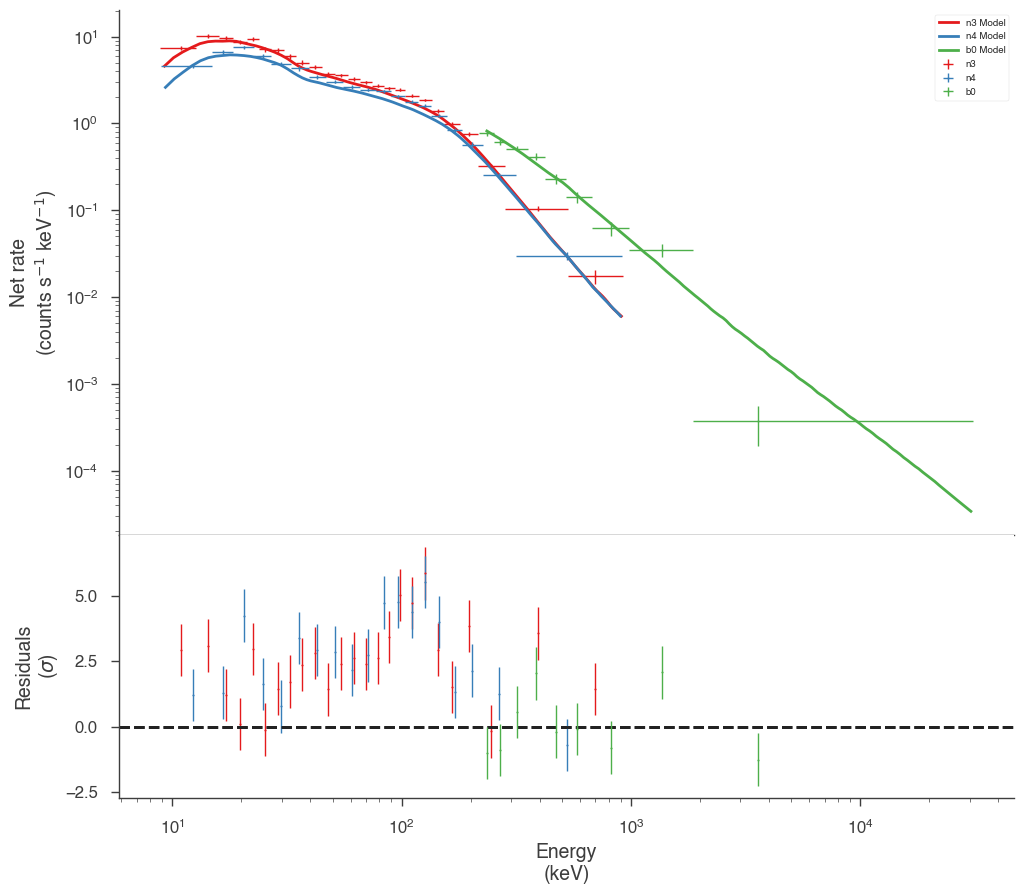

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


 ln(ev)=  -3101.1617965901596      +/-  0.22437612523835734     
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:        23896
 Sampling finished. Exiting MultiNest


09:25:57 INFO      fit restored to maximum of posterior                                         ]8;id=800928;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=597795;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=364880;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=138277;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.4540 -0.0019 +0.034) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.0964 +0.0033 +0.04,
GRB080916009...break_energy,(1.90 +0.14 +0.7) x 10^2,keV
GRB080916009...break_scale,(0.0 +1.7 +3.4) x 10^-1,
GRB080916009...beta,-1.96 -0.24 -0.05,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1050.016311
n3,-1018.713540
n4,-1010.979612
total,-3079.709463


Values of statistical measures:

,statistical measures
AIC,6169.589381
BIC,6188.821592
DIC,6179.846524
PDIC,4.332335
log(Z),-1346.817456


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=586997;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=357161;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

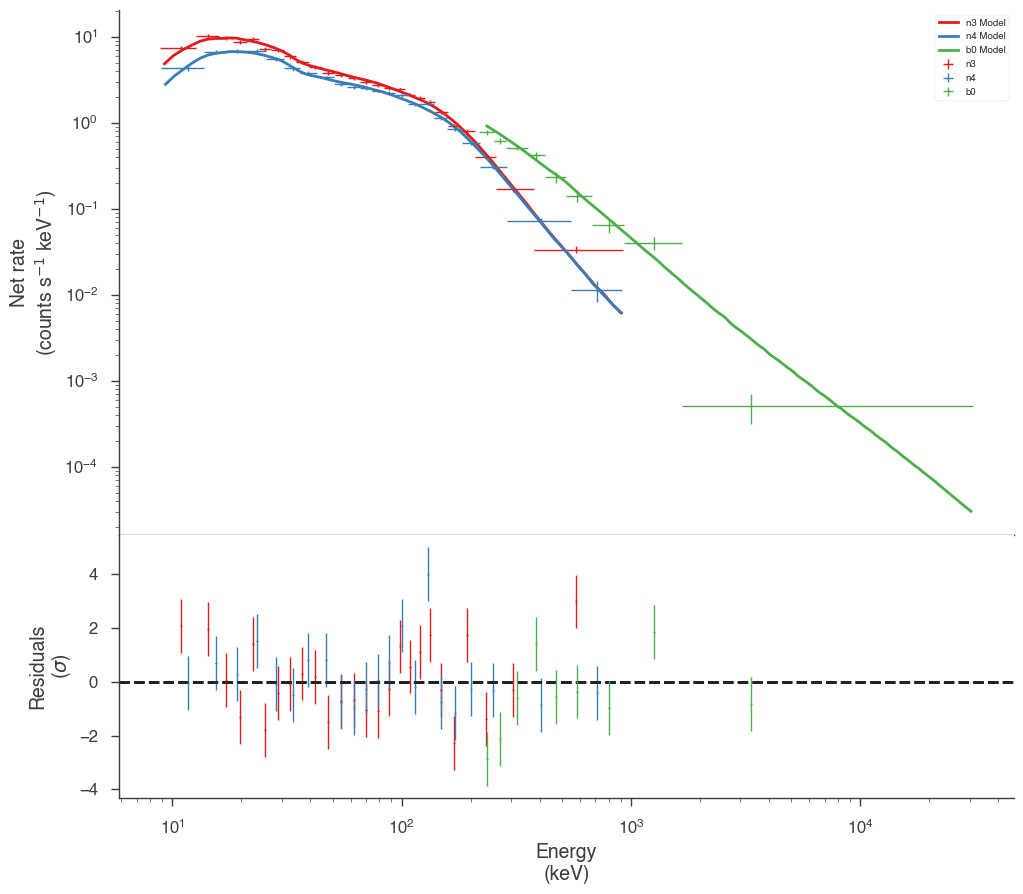

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

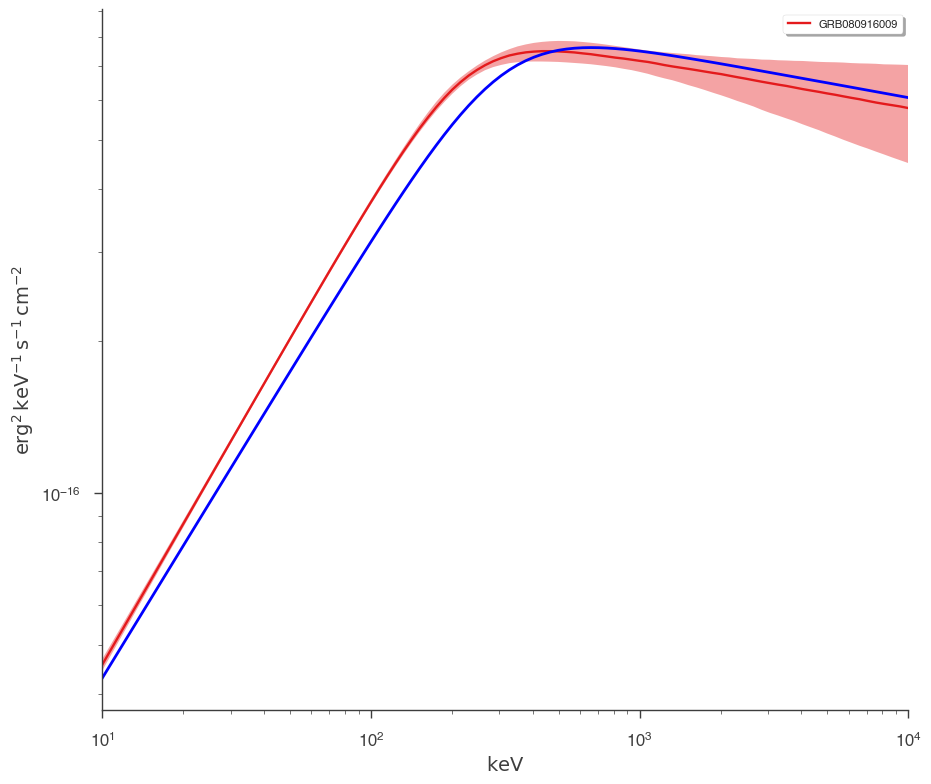

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

09:27:59 INFO      Created 15 bins via bayesblocks                                       ]8;id=341117;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=653504;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#754\754]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


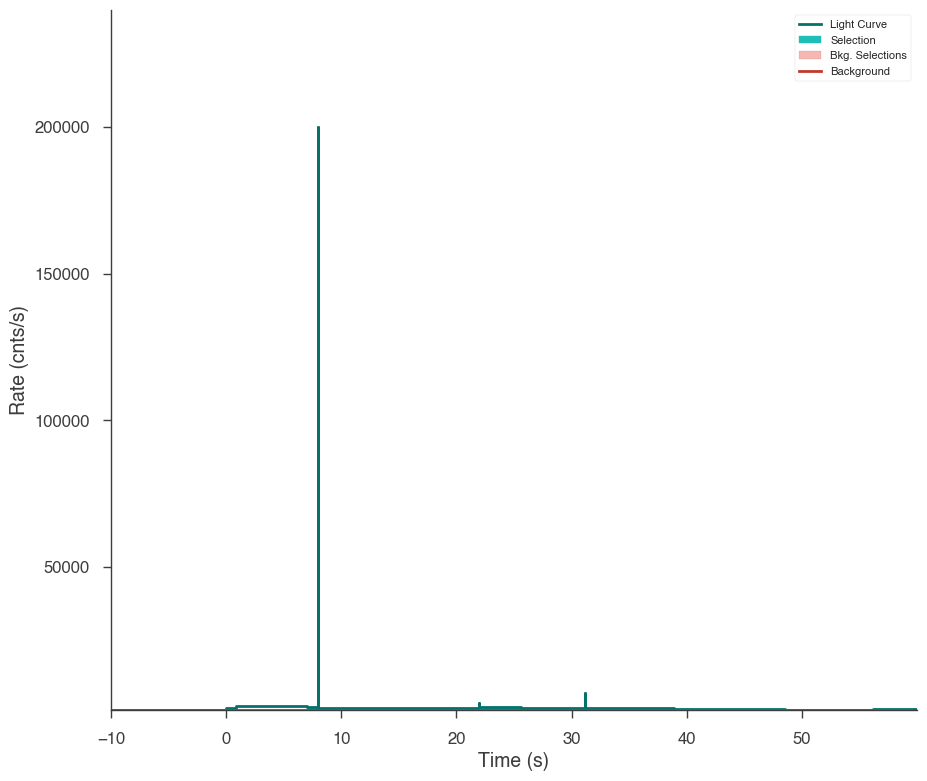

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

09:28:00 INFO      Created 12 bins via custom                                            ]8;id=976204;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=255269;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#754\754]8;;\

Now our light curve looks much more acceptable.

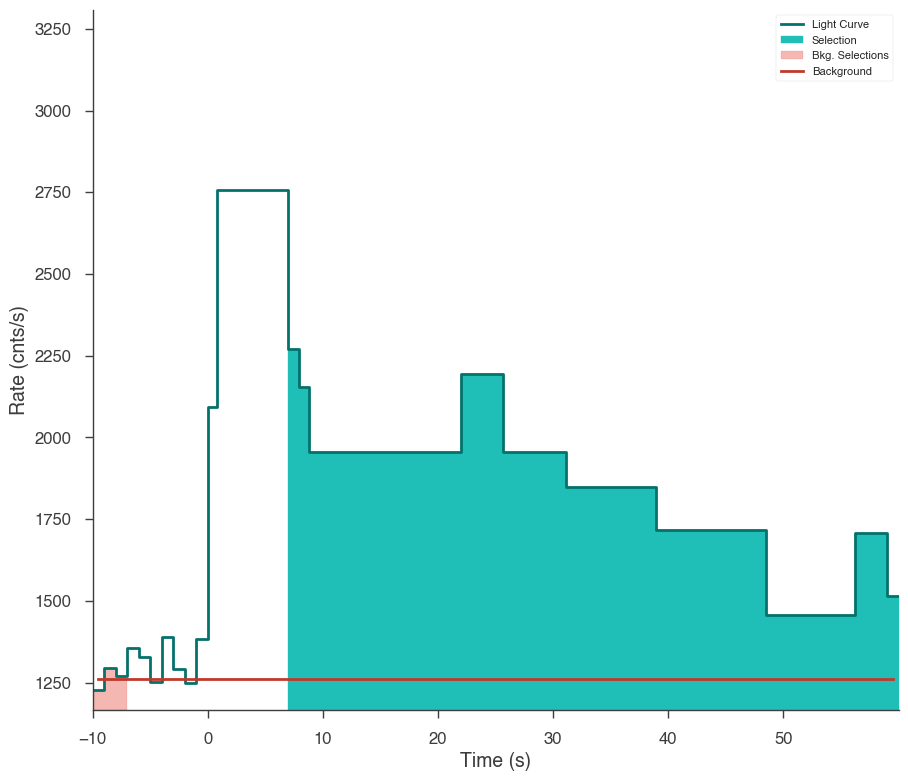

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=896804;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=673928;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#754\754]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

09:28:01 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=163086;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=30183;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#351\351]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=698896;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=890919;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#754\754]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=229435;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=771937;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#351\351]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=120935;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=505770;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#754\754]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

09:28:02 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=132653;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=627312;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#351\351]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=602184;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=84833;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=141506;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=273133;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=209614;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=226141;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=648691;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=507778;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=978315;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=290085;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 107 bins                                                          ]8;id=957983;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=128774;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=546552;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=883914;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -789.03137231882226      +/-  0.17855806956606457     
 Total Likelihood Evaluations:        16382
 Sampling finished. Exiting MultiNest



09:28:18 INFO      fit restored to maximum of posterior                                         ]8;id=854948;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=706603;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=327517;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=987793;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.69 -0.32 +0.8) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.2 -1.0 +1.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.05 -0.6 +0.33) x 10^2,keV
grb.spectrum.main.Band.beta,-2.06 -0.21 +0.16,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-285.620979
n3_interval0,-250.121379
n4_interval0,-268.039816
total,-803.782175


Values of statistical measures:

,statistical measures
AIC,1615.677664
BIC,1631.086481
DIC,1570.175273
PDIC,2.523412
log(Z),-342.671971


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=707823;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=208188;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=812802;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=653979;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=876455;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=236562;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=554186;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=983981;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=572419;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=406555;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=686972;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=401856;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=975555;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=259274;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -1943.0887144008655      +/-  0.21171834931087913     
 Total Likelihood Evaluations:        22738
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


09:28:39 INFO      fit restored to maximum of posterior                                         ]8;id=185779;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=886458;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=248084;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=54823;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(4.09 -0.12 +0.15) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.66 -0.23 +0.33) x 10^-1,
grb.spectrum.main.Band.xp,(6.3 -0.6 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.14 -0.12 +0.06,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-673.698039
n3_interval1,-642.009403
n4_interval1,-645.680816
total,-1961.388257


Values of statistical measures:

,statistical measures
AIC,3930.889828
BIC,3946.298646
DIC,3873.593077
PDIC,3.749792
log(Z),-843.872707


09:28:40 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=331731;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=77311;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=575986;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=757820;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=872817;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=745088;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=610674;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=865336;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=384654;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=169465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 115 bins                                                          ]8;id=922427;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=745495;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=181001;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=529631;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -905.14777276015889      +/-  0.18864434493390406     
 Total Likelihood Evaluations:        22872
 Sampling finished. Exiting MultiNest



09:29:00 INFO      fit restored to maximum of posterior                                         ]8;id=264077;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=250211;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=740915;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=85928;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.54 -0.26 +0.19) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.05 -0.08 +0.06,
grb.spectrum.main.Band.xp,(6.0 -1.2 +3.1) x 10^2,keV
grb.spectrum.main.Band.beta,-1.89 -0.4 +0.10,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-324.471810
n3_interval2,-289.023260
n4_interval2,-312.696335
total,-926.191405


Values of statistical measures:

,statistical measures
AIC,1860.496124
BIC,1875.904941
DIC,1805.440969
PDIC,2.721006
log(Z),-393.100683


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=12433;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=390640;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=649379;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=858501;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=18365;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=620667;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=748869;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=230247;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=631502;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=604817;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 109 bins                                                          ]8;id=289823;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=153712;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=863749;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=552125;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.12744397675704      +/-  0.17595044326275663     
 Total Likelihood Evaluations:        17717
 Sampling finished. Exiting MultiNest



09:29:16 INFO      fit restored to maximum of posterior                                         ]8;id=185573;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=453682;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=756457;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=568655;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.89 -0.35 +0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.3 -0.8 +1.0) x 10^-1,
grb.spectrum.main.Band.xp,(3.4 -0.6 +0.9) x 10^2,keV
grb.spectrum.main.Band.beta,-2.23 -0.4 +0.19,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.406410
n3_interval3,-242.571317
n4_interval3,-262.517634
total,-803.495361


Values of statistical measures:

,statistical measures
AIC,1615.104036
BIC,1630.512853
DIC,1570.797787
PDIC,3.109316
log(Z),-342.279400


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=747016;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=544174;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=687649;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=60929;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=93213;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=264938;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=655032;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=862086;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=772604;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=618274;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=215644;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=210616;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=709801;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=343521;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2272.1351538161994      +/-  0.20211992534430817     
 Total Likelihood Evaluations:        20733
 Sampling finished. Exiting MultiNest



09:29:36 INFO      fit restored to maximum of posterior                                         ]8;id=864207;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=200124;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=302554;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=615138;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.071 +0.014 +0.19) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.740 -0.011 +0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.895 -0.6 +0.013) x 10^2,keV
grb.spectrum.main.Band.beta,-1.97 -0.10 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-778.392733
n3_interval4,-757.191286
n4_interval4,-746.584632
total,-2282.168650


Values of statistical measures:

,statistical measures
AIC,4572.450614
BIC,4587.859432
DIC,4527.211108
PDIC,2.608111
log(Z),-986.775759


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=845995;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=536026;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=105889;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=741057;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=442772;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=767240;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=499351;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=602669;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=341212;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=599740;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=242541;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=709091;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=56431;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=813159;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1573.1902141103394      +/-  0.19240430835895669     
 Total Likelihood Evaluations:        19794
 Sampling finished. Exiting MultiNest



09:29:54 INFO      fit restored to maximum of posterior                                         ]8;id=447355;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=196552;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=178059;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=455308;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.82 -0.22 +0.16) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.1 -0.6 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(4.14 -0.32 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.09 -0.32 +0.04,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-536.767153
n3_interval5,-523.455640
n4_interval5,-527.631245
total,-1587.854038


Values of statistical measures:

,statistical measures
AIC,3183.821390
BIC,3199.230207
DIC,3136.456683
PDIC,3.186753
log(Z),-683.227829


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=451323;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=889910;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=538163;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=475320;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=261520;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=769166;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=267737;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=533904;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=649104;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=740826;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=33255;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=51858;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=871464;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=249740;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt
 ln(ev)=  -1755.1164270935642      +/-  0.19195702051537678     
 Total Likelihood Evaluations:        21298
 Sampling finished. Exiting MultiNest


09:30:13 INFO      fit restored to maximum of posterior                                         ]8;id=95748;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=591510;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=79617;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=963982;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.95 -0.12 +0.13) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.01 +/- 0.05,
grb.spectrum.main.Band.xp,(4.4 -0.5 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.29 -0.4 +0.10,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-609.486615
n3_interval6,-584.216575
n4_interval6,-576.700836
total,-1770.404026


Values of statistical measures:

,statistical measures
AIC,3548.921366
BIC,3564.330183
DIC,3501.078886
PDIC,3.291061
log(Z),-762.237379


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=858751;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=614419;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=264936;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=465249;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=536667;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=390540;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=887169;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=975369;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=217404;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=933058;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=472594;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=463616;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=119227;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=767997;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1940.4996630230039      +/-  0.19620765238879020     
 Total Likelihood Evaluations:        19251
 Sampling finished. Exiting MultiNest



09:30:31 INFO      fit restored to maximum of posterior                                         ]8;id=886127;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=541056;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=964764;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=38035;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.68 -0.07 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.040 -0.032 +0.05,
grb.spectrum.main.Band.xp,(4.2 -0.6 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.20 -0.08 +0.15,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.269837
n3_interval7,-640.792684
n4_interval7,-650.248022
total,-1953.310543


Values of statistical measures:

,statistical measures
AIC,3914.734401
BIC,3930.143218
DIC,3867.242411
PDIC,2.607596
log(Z),-842.748296


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=391033;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=596896;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=162378;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=620355;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=776824;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=353416;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=591328;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=707586;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=90557;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=725769;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=229530;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=301016;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=986190;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=158727;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2054.3517775144301      +/-  0.18982927710553904     
 Total Likelihood Evaluations:        18324
 Sampling finished. Exiting MultiNest



09:30:49 INFO      fit restored to maximum of posterior                                         ]8;id=219558;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=860818;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=596006;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=658000;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.52 -0.07 +0.16) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.59 -0.32 +0.8) x 10^-1,
grb.spectrum.main.Band.xp,(3.8 -0.5 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.32 -0.4 +0.15,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-702.252851
n3_interval8,-698.436257
n4_interval8,-666.340084
total,-2067.029192


Values of statistical measures:

,statistical measures
AIC,4142.171699
BIC,4157.580516
DIC,4097.596112
PDIC,3.029385
log(Z),-892.193641


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=331840;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=263367;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=13301;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=178864;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=525525;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=477358;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=316271;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=748299;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=218882;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=259534;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=575845;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=131374;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=239378;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=521293;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.6674227576736      +/-  0.14503276179916627     
 Total Likelihood Evaluations:        12625
 Sampling finished. Exiting MultiNest



09:31:00 INFO      fit restored to maximum of posterior                                         ]8;id=596329;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=979910;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=835089;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=336975;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.1 -0.4 +1.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.6 -2.1 +4) x 10^-1,
grb.spectrum.main.Band.xp,(1.1 -0.4 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-1.83 -0.4 +0.09,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.685443
n3_interval9,-616.939773
n4_interval9,-616.121842
total,-1881.747057


Values of statistical measures:

,statistical measures
AIC,3771.607429
BIC,3787.016247
DIC,3657.559609
PDIC,-89.833077
log(Z),-815.894895


09:31:01 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=621242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=418441;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=282022;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=886893;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=63568;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=137432;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=469376;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=82919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=733232;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=817936;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=807242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=48221;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=116629;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=52791;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1321.8341081827932      +/-  0.16560769603086373     
 Total Likelihood Evaluations:        15415
 Sampling finished. Exiting MultiNest



09:31:15 INFO      fit restored to maximum of posterior                                         ]8;id=804525;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=818709;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=6895;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=224339;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.0 -0.4 +0.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.6 -1.3 +1.7) x 10^-1,
grb.spectrum.main.Band.xp,(2.2 -0.4 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-1.925 -0.5 +0.033,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.933651
n3_interval10,-437.629286
n4_interval10,-433.171044
total,-1331.733981


Values of statistical measures:

,statistical measures
AIC,2671.581276
BIC,2686.990093
DIC,2633.761724
PDIC,-0.322227
log(Z),-574.065259


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=262785;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=365493;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=606978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=482653;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=904428;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=157917;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=190481;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=718783;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=463551;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=945406;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=42873;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=837692;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=117173;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=697721;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -812.74401041334670      +/-  0.15118811274780575     
 Total Likelihood Evaluations:        11765
 Sampling finished. Exiting MultiNest



09:31:27 INFO      fit restored to maximum of posterior                                         ]8;id=519272;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=329935;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=222188;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=981192;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.6 -0.7 +2.0) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.5 -1.8 +3.4) x 10^-1,
grb.spectrum.main.Band.xp,(1.33 -0.32 +0.24) x 10^2,keV
grb.spectrum.main.Band.beta,-2.16 -0.5 +0.34,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.299900
n3_interval11,-272.637407
n4_interval11,-255.593125
total,-820.530432


Values of statistical measures:

,statistical measures
AIC,1649.174178
BIC,1664.582995
DIC,1618.447233
PDIC,0.932040
log(Z),-352.970239


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=545959;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=111954;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:28 INFO      fit restored to median of posterior                                          ]8;id=513280;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=189959;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:29 INFO      fit restored to median of posterior                                          ]8;id=94830;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=564340;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:30 INFO      fit restored to median of posterior                                          ]8;id=473935;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=432040;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:31 INFO      fit restored to median of posterior                                          ]8;id=780672;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=872556;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:32 INFO      fit restored to median of posterior                                          ]8;id=602091;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=71550;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=994470;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=747410;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:33 INFO      fit restored to median of posterior                                          ]8;id=853713;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=83784;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:34 INFO      fit restored to median of posterior                                          ]8;id=942947;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=16804;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:35 INFO      fit restored to median of posterior                                          ]8;id=47764;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=624530;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:36 INFO      fit restored to median of posterior                                          ]8;id=455779;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=634587;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:31:37 INFO      fit restored to median of posterior                                          ]8;id=667021;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=690313;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

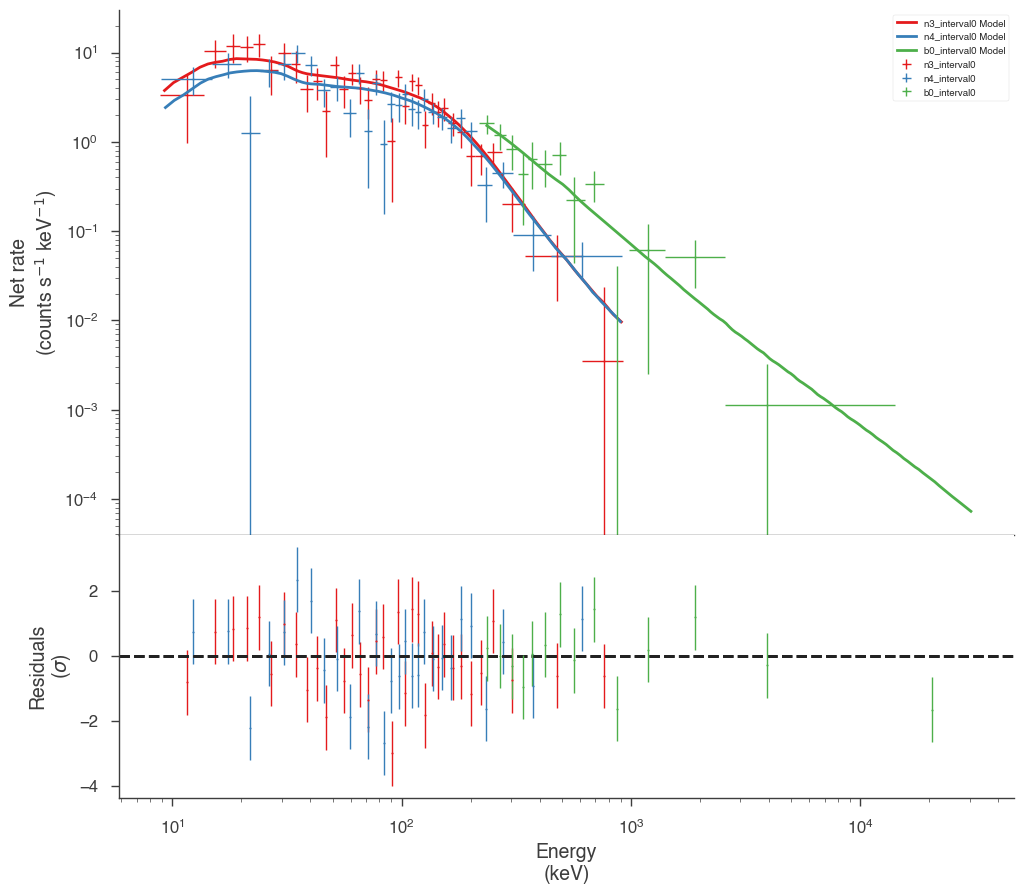

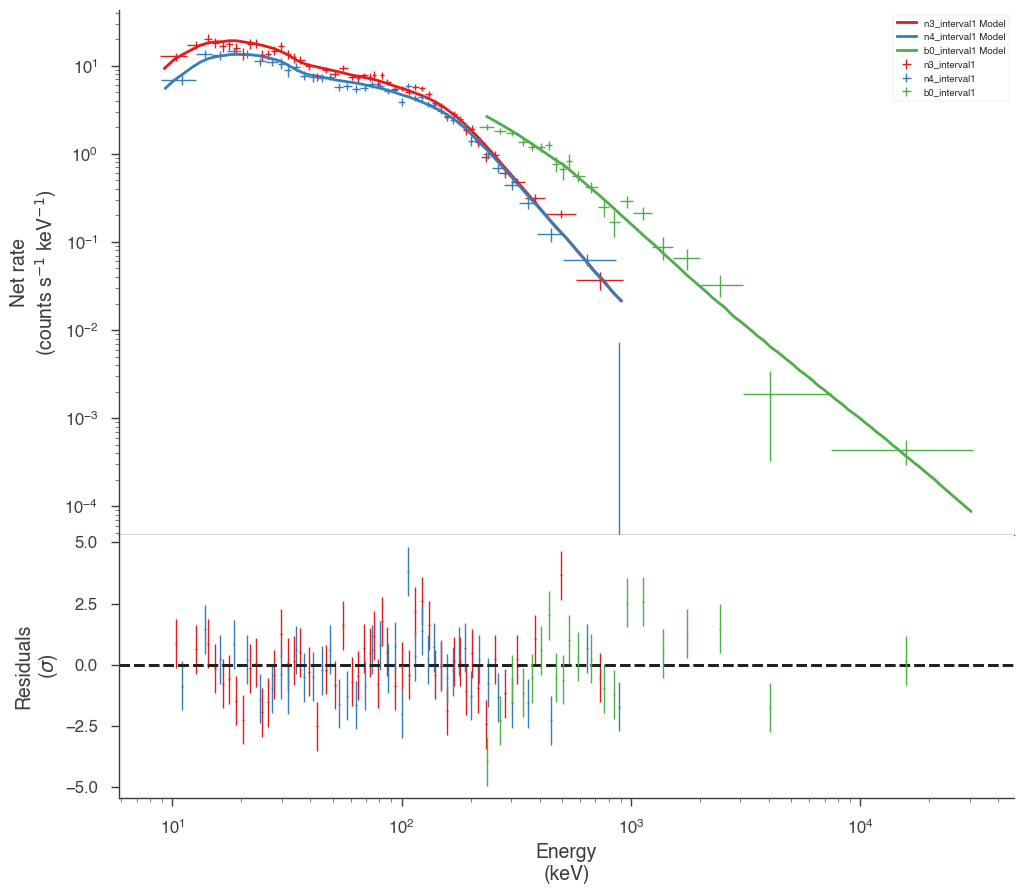

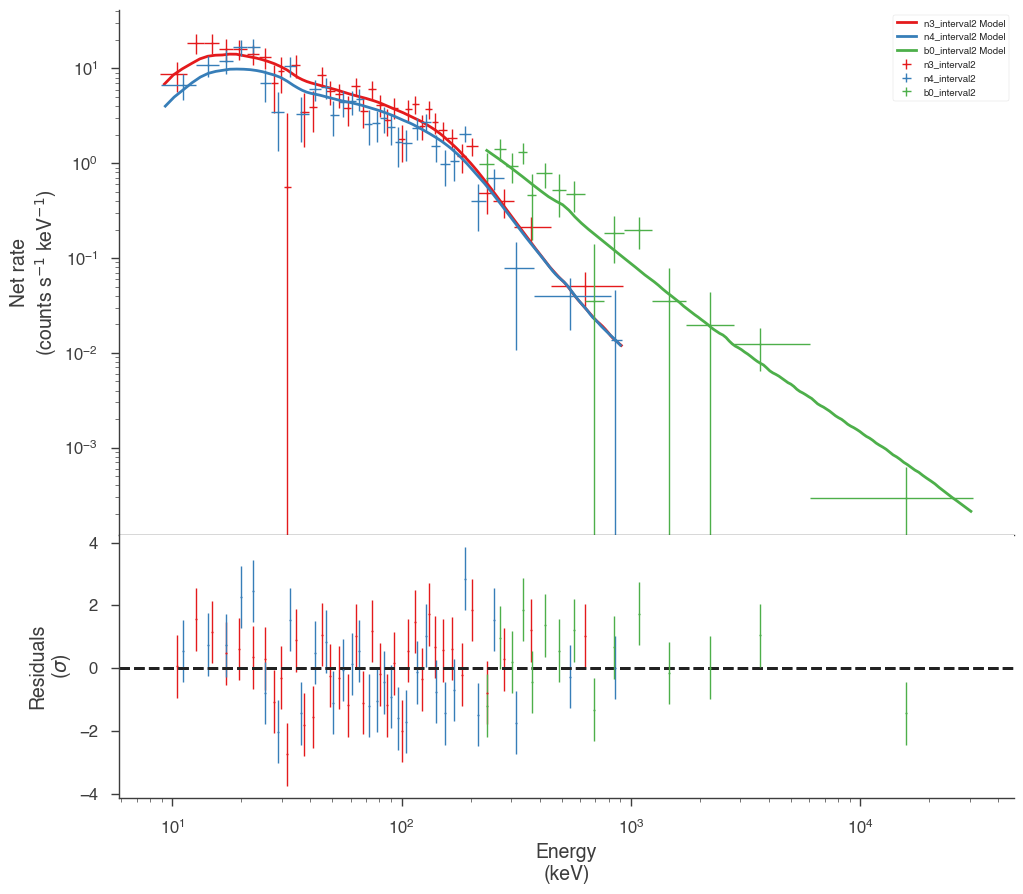

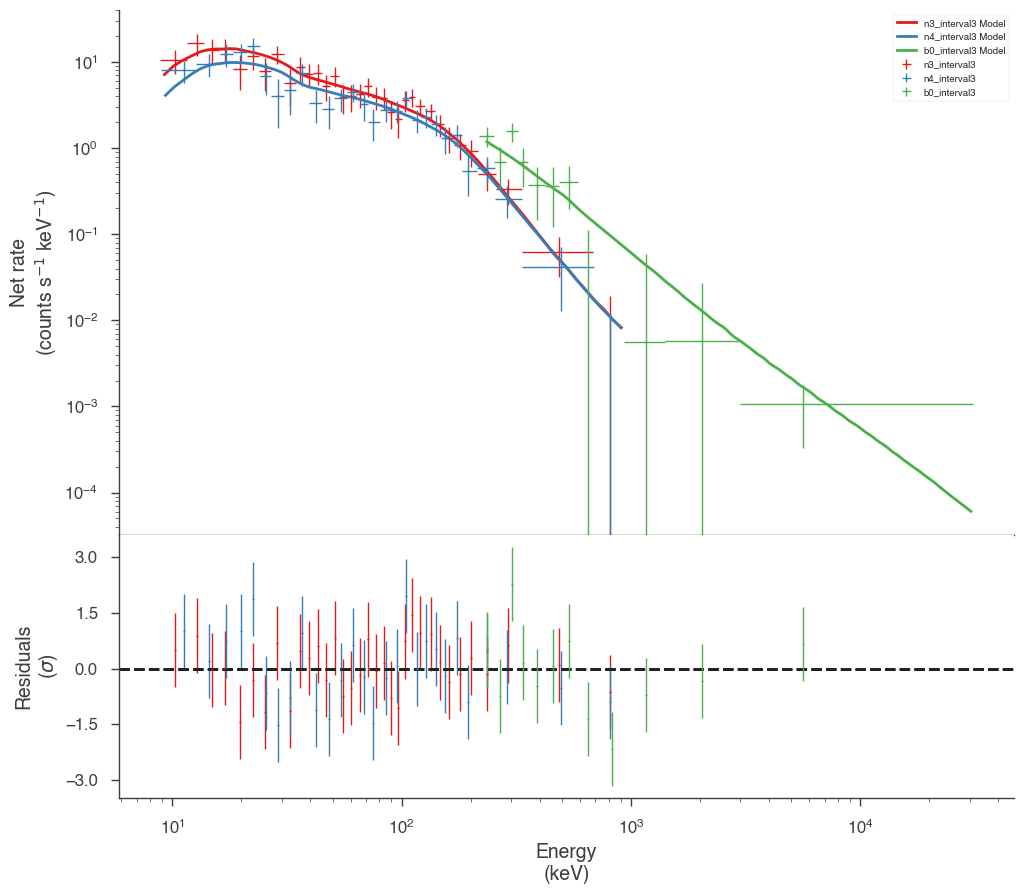

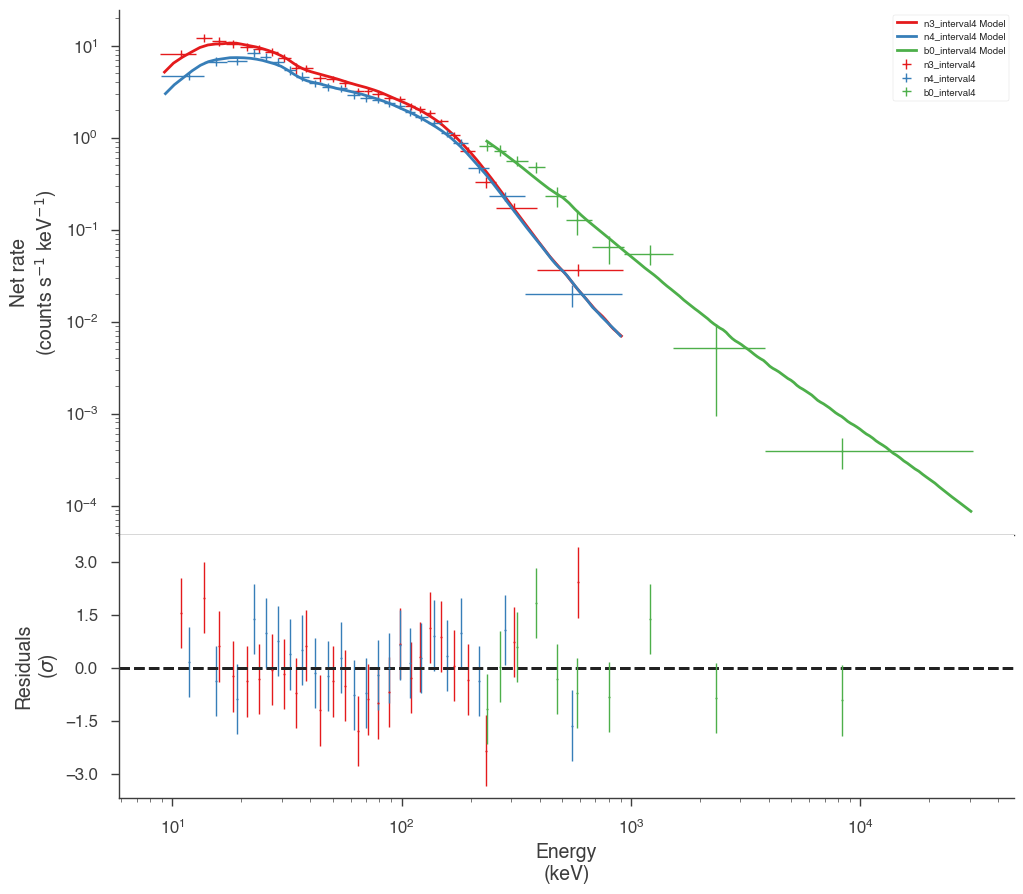

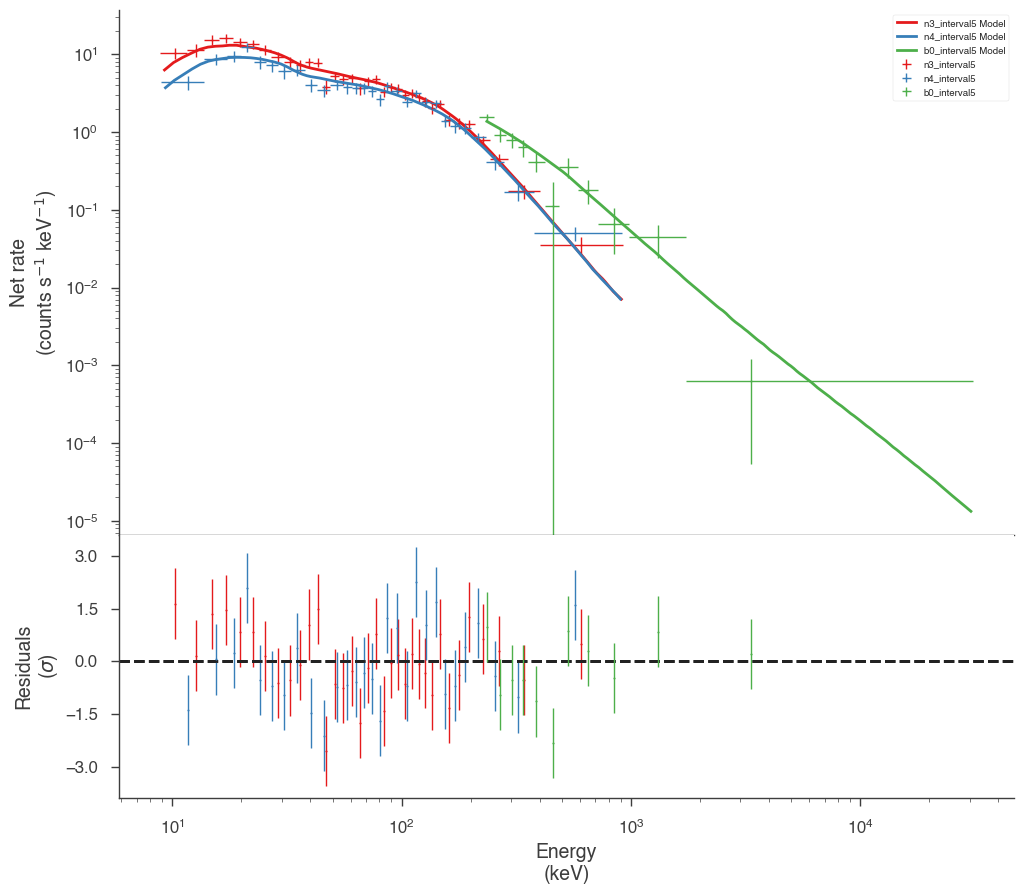

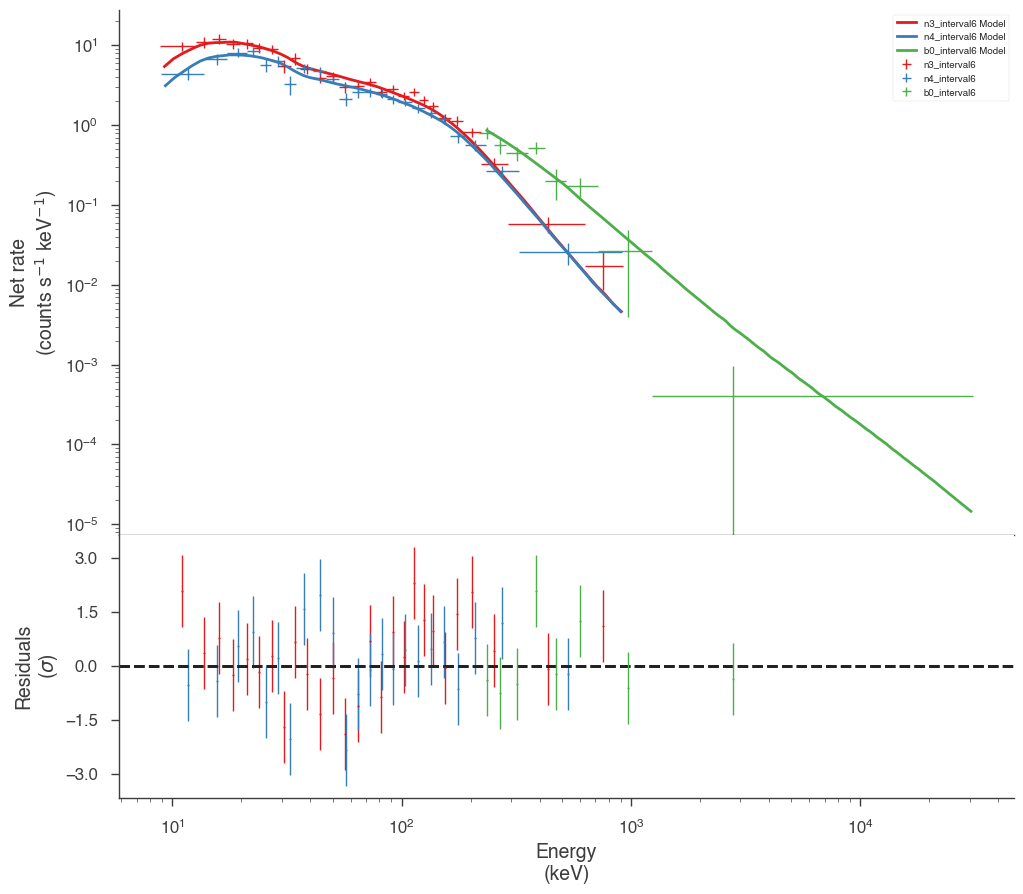

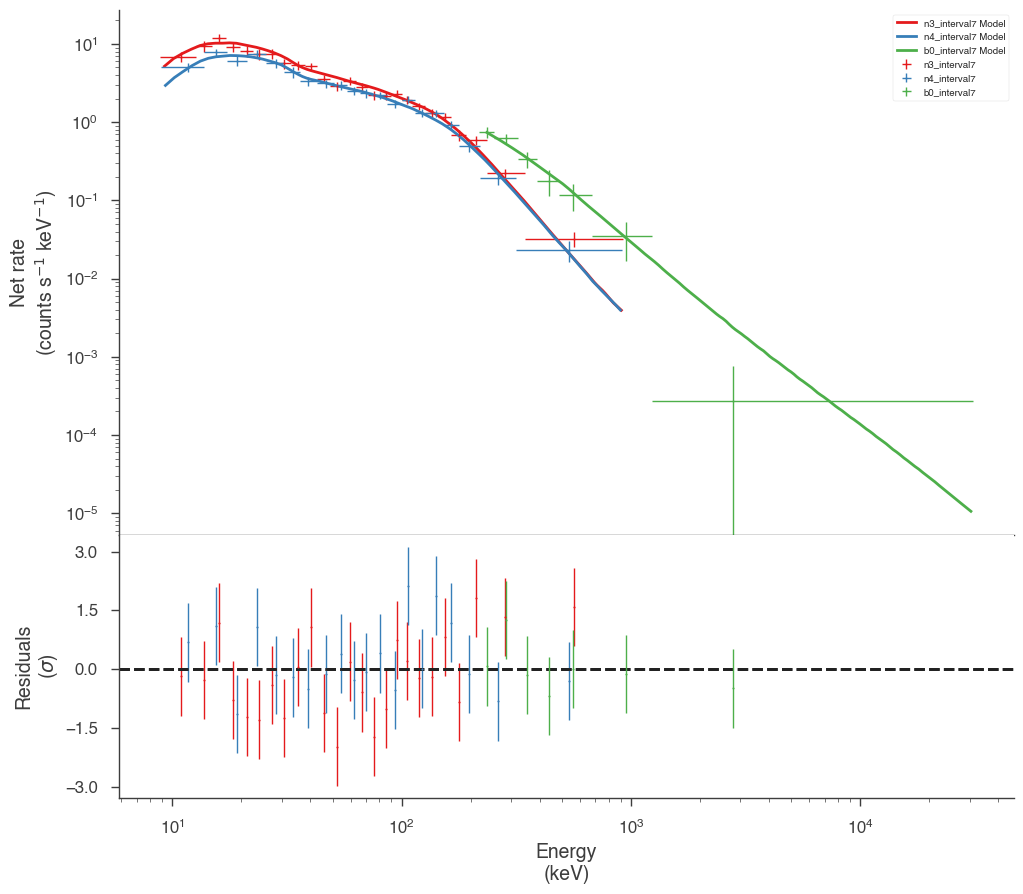

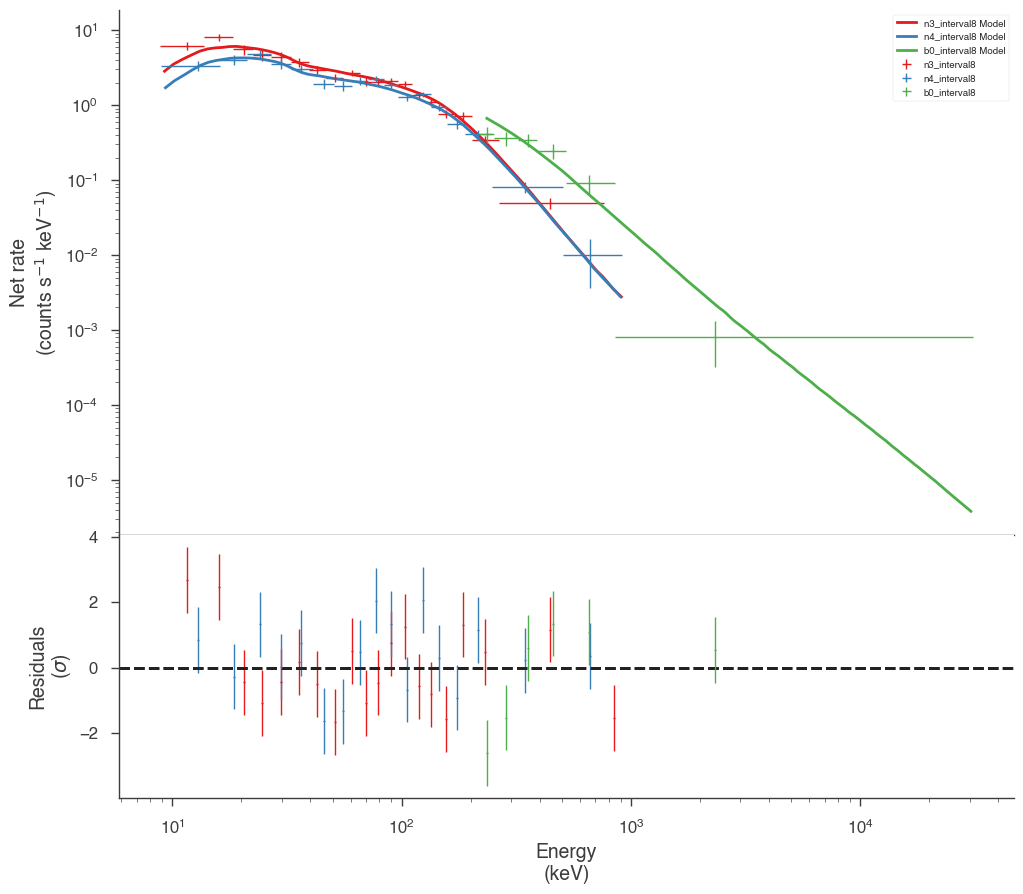

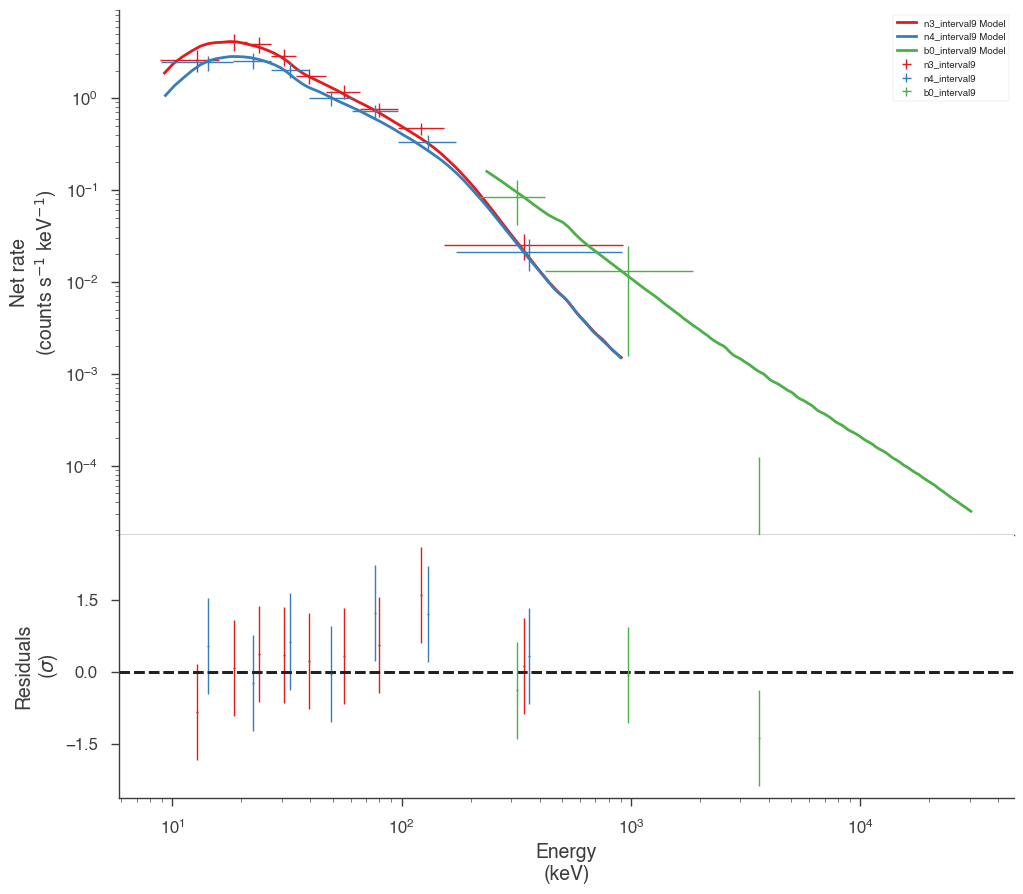

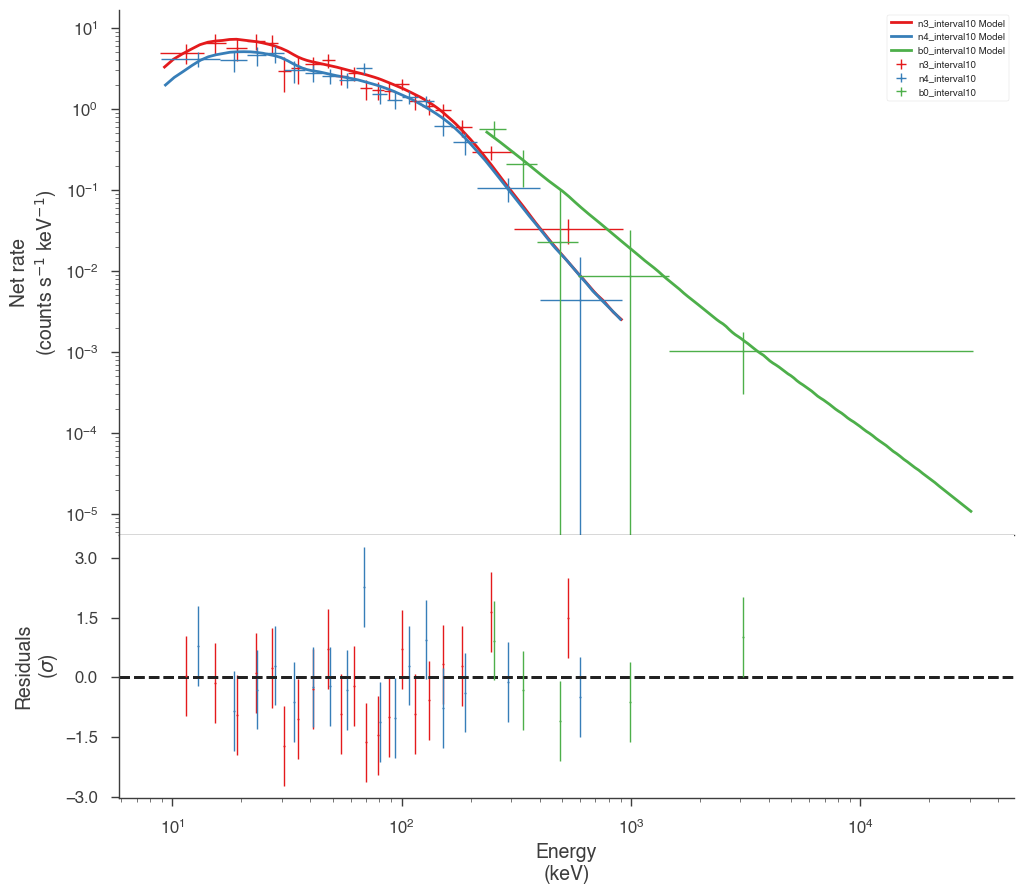

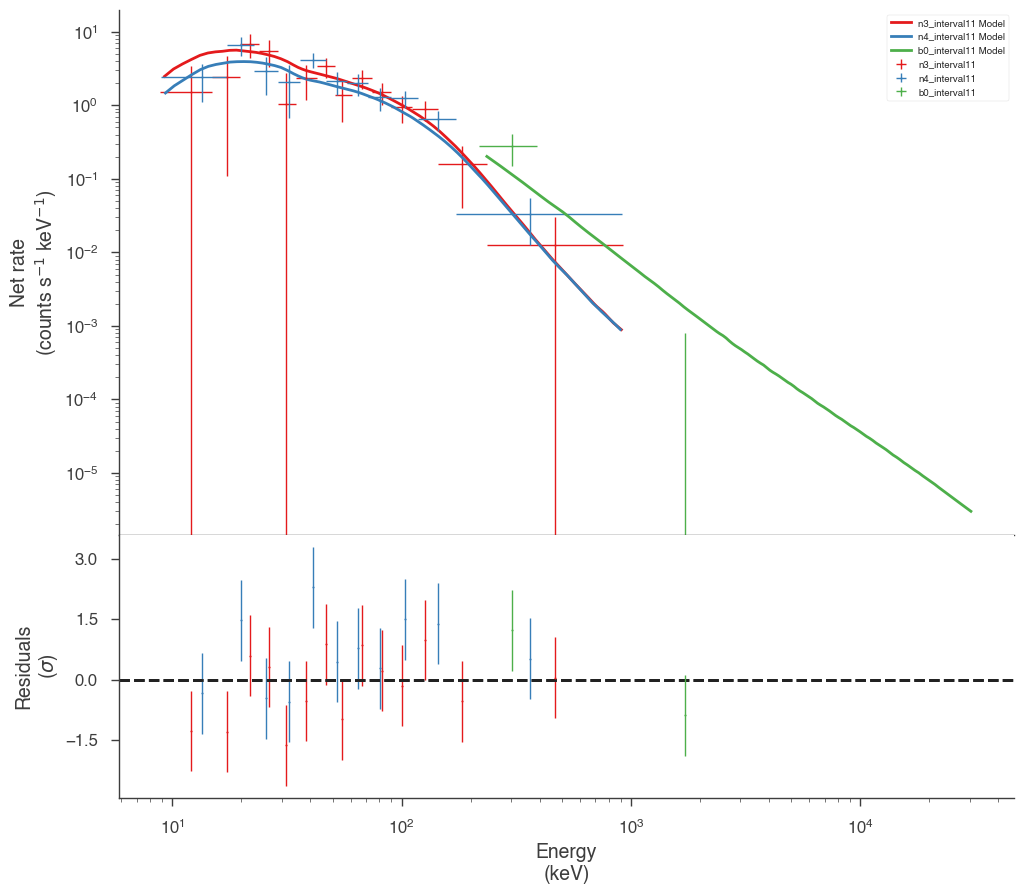

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

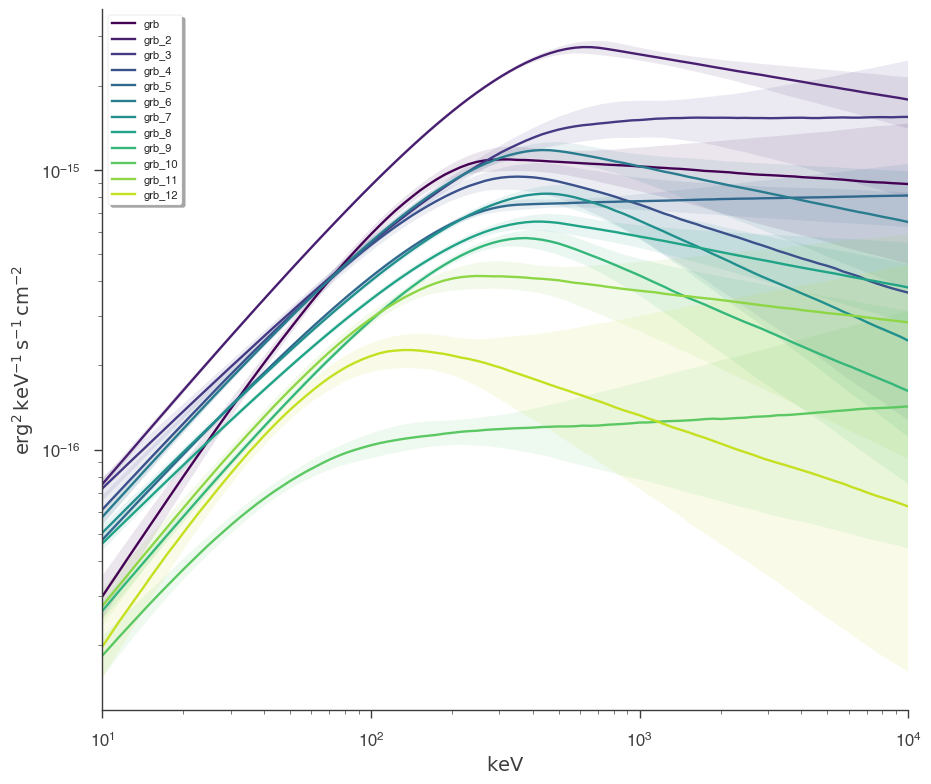

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.